In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import sys
sys.path.append('..')
from dataset import batcher

In [23]:
MODEL_DIR = '../saved_models/'
GRID_SEARCH_DIR = '../saved_models/grid_search_all/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [20]:
# Get test split
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
# bands = ['VIIRS', 'BLUE']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 10)


In [29]:
# Load model
experiments = ['imagery_sample_cnn_regression_2560.001gelu']

def load_model_from_dir(model_name):
    model_path = GRID_SEARCH_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [30]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-05-29 10:06:09.835531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[4.288069 ]
 [5.451262 ]
 [4.187958 ]
 [5.925644 ]
 [4.1152077]
 [4.340033 ]
 [4.3437295]
 [4.2955656]
 [4.305231 ]
 [4.3168974]
 [4.1976795]
 [4.42132  ]
 [5.9669194]
 [4.1345825]
 [4.6791162]
 [4.3632717]
 [6.1260943]
 [5.0564585]
 [4.319349 ]
 [4.458247 ]
 [4.162443 ]
 [7.033799 ]
 [4.2800474]
 [4.2359886]
 [4.2007303]
 [3.9167137]
 [4.2411747]
 [4.4066772]
 [4.325449 ]
 [4.2900114]
 [4.070051 ]
 [4.3978186]
 [4.1698313]
 [4.041664 ]
 [5.82362  ]
 [4.303733 ]
 [4.3978186]
 [4.8326387]
 [4.305231 ]
 [5.938103 ]
 [4.2683516]
 [7.809903 ]
 [4.194606 ]
 [4.4820004]
 [6.5810184]
 [4.2403154]
 [4.330494 ]
 [4.354571 ]
 [4.039503 ]
 [4.3500686]
 [4.30832  ]
 [4.3168974]
 [4.3445582]
 [5.871026 ]
 [6.5132375]
 [4.8095903]
 [8.544327 ]
 [4.3742223]
 [5.73796  ]
 [7.0141344]
 [4.350374 ]
 [4.3889084]
 [4.3000026]
 [4.2151   ]
 [4.162443 ]
 [4.3562193]
 [3.3295405]
 [8.210485 ]
 [5.82362  ]
 [4.286796 ]
 [4.0298853]
 [4.366469 ]
 [4.50685  ]
 [4.274408 ]
 [4.237082 ]
 [4.366469 ]
 [6.4597454]

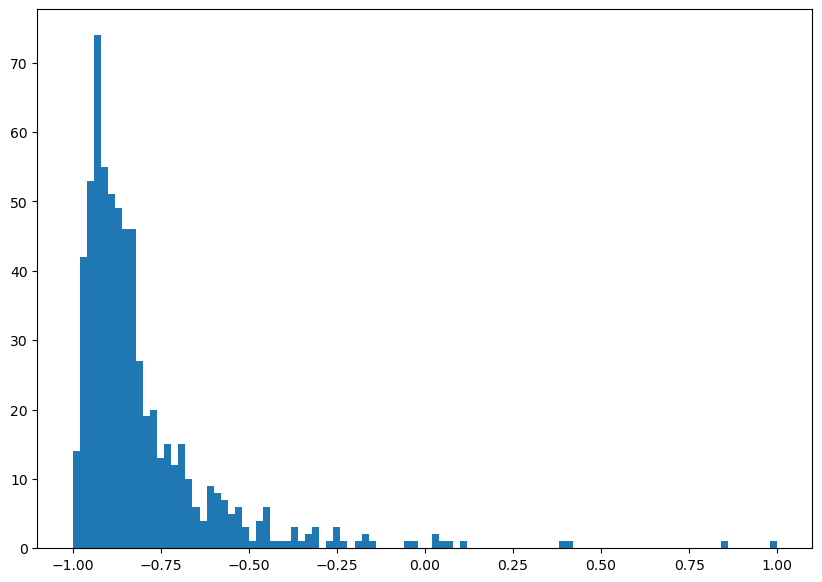

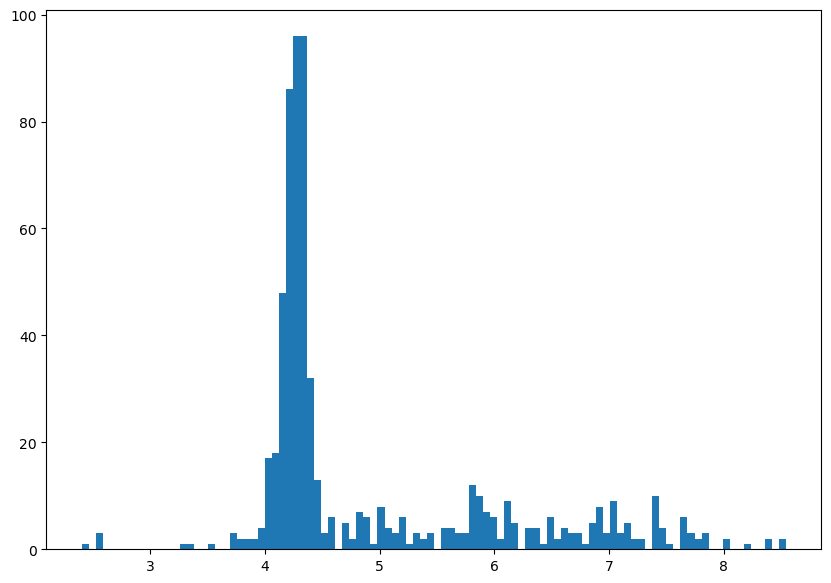

In [31]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds = 2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

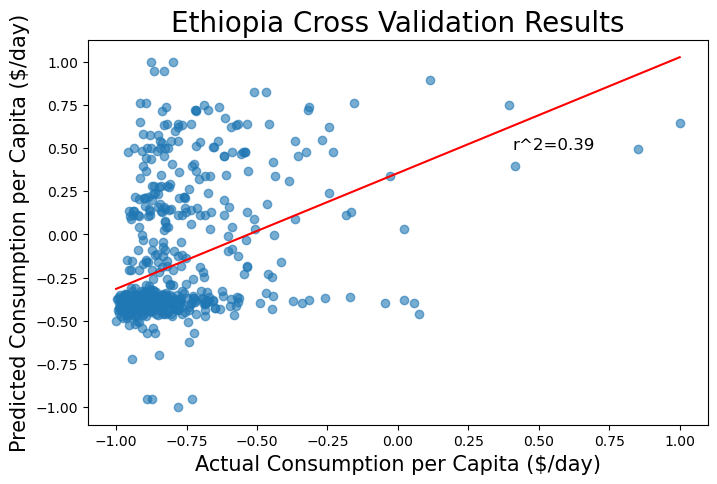

In [32]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()